Dataset shape: (1000, 21)
  checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                       4         male single          none  ...   
1                       2  female div/

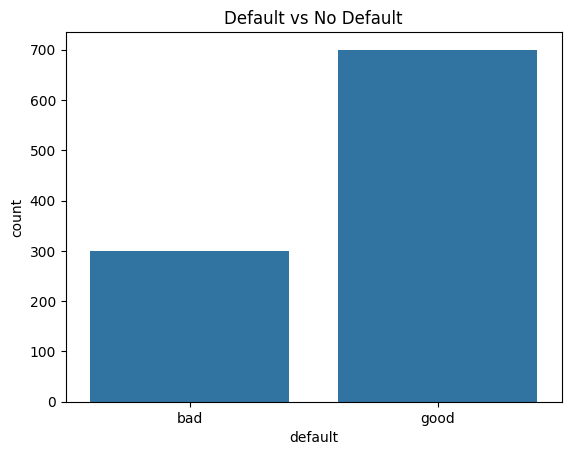

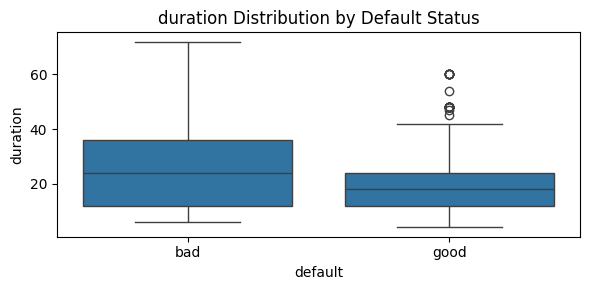

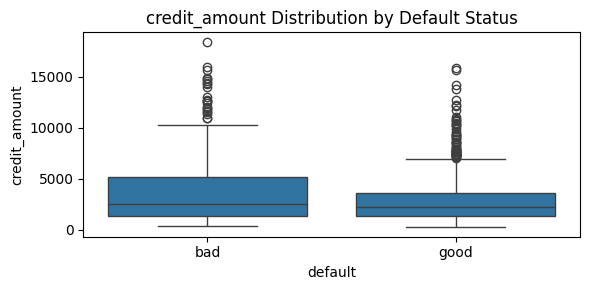

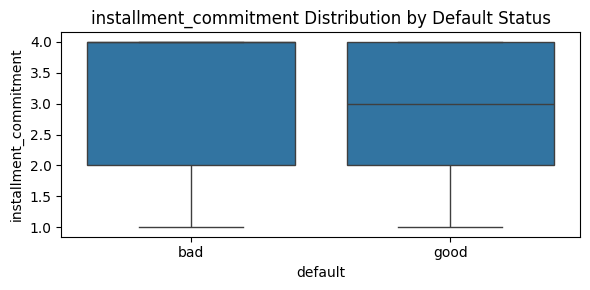

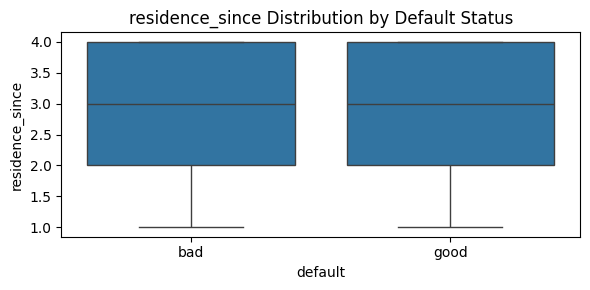

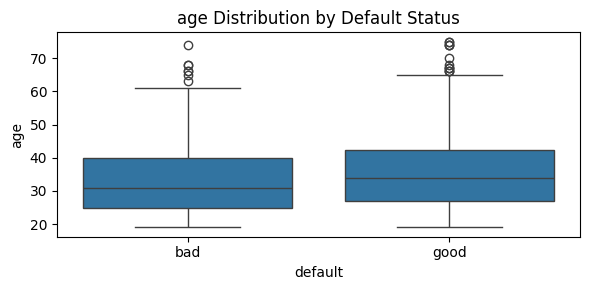

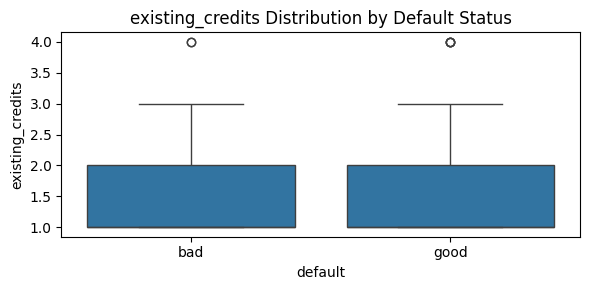

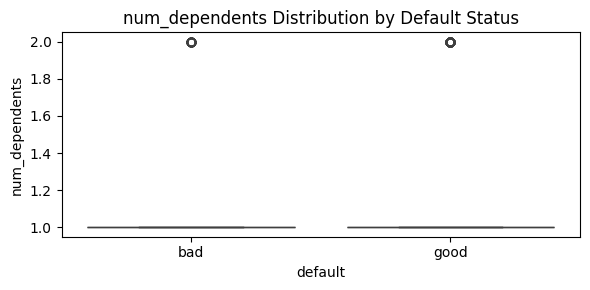


Final dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   int64  
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   int64  
 3   purpose                 1000 non-null   int64  
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   int64  
 6   employment              1000 non-null   int64  
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   int64  
 9   other_parties           1000 non-null   int64  
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   int64  
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   int64  
 14  housing        

In [1]:
# Task 1: Data Analysis and Cleaning


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.datasets import fetch_openml

# Load the "credit-g" dataset from OpenML
credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)
df = credit_data.frame

# Rename target column for clarity
df.rename(columns={'class': 'default'}, inplace=True)

# Basic dataset info
print("Dataset shape:", df.shape)
print(df.head())

# Summary statistics
print("\nSummary statistics:")
print(df.describe(include='all'))

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Visualize class distribution
sns.countplot(x='default', data=df)
plt.title("Default vs No Default")
plt.show()

# Visualize distributions of numerical features vs default
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='default', y=col, data=df)
    plt.title(f"{col} Distribution by Default Status")
    plt.tight_layout()
    plt.show()

# Encode categorical variables
cat_cols = df.select_dtypes(include=['category', 'object']).columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle missing values (fallback for safety)
df.fillna(df.median(numeric_only=True), inplace=True)

# Scale numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Final dataset info
print("\nFinal dataset structure:")
print(df.info())


In [2]:
# Task 2: Feature Engineering
# Feature Engineering (hypothetical example)
# If the dataset included relevant financial columns, you could create:
# df['debt_to_income'] = df['existing_debt'] / (df['income'] + 1)

# In this case, the dataset lacks such columns, so no new features are added

# Define features and target
X = df.drop(columns='default')
y = df['default']



Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.38      0.48        60
           1       0.77      0.91      0.84       140

    accuracy                           0.75       200
   macro avg       0.71      0.65      0.66       200
weighted avg       0.73      0.75      0.73       200



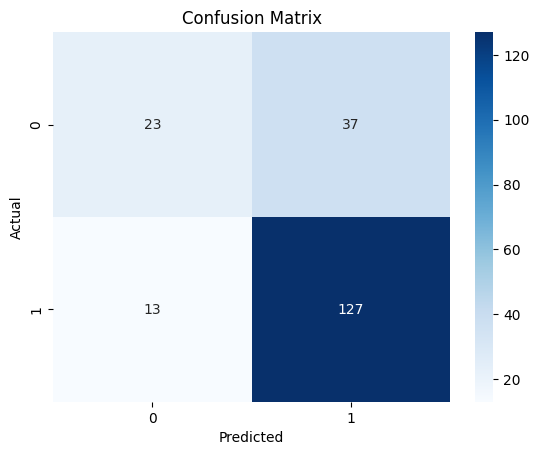

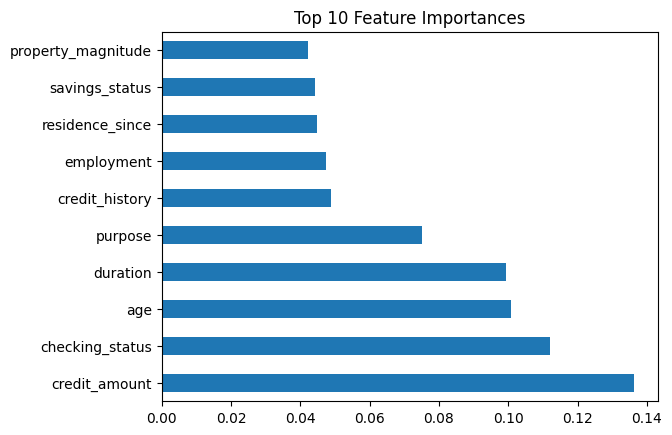

In [3]:
# Task 3: Model Building and Evaluation

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)
# Train Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Feature importance
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.4 MB/s eta 0:00:00
SHAP values shape: (200, 20, 2)


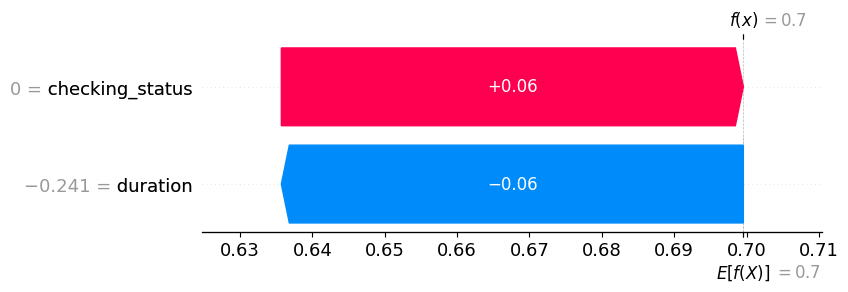

📊 Fairness Metrics by Group:
                 accuracy  selection_rate  false_positive_rate  \
checking_status                                                  
0                0.676471        0.720588                 0.56   
1                0.673469        0.693878                 0.52   
2                0.750000        0.916667                 1.00   
3                0.873239        0.985915                 1.00   

                 true_positive_rate  
checking_status                      
0                          0.813953  
1                          0.875000  
2                          0.900000  
3                          0.984127  


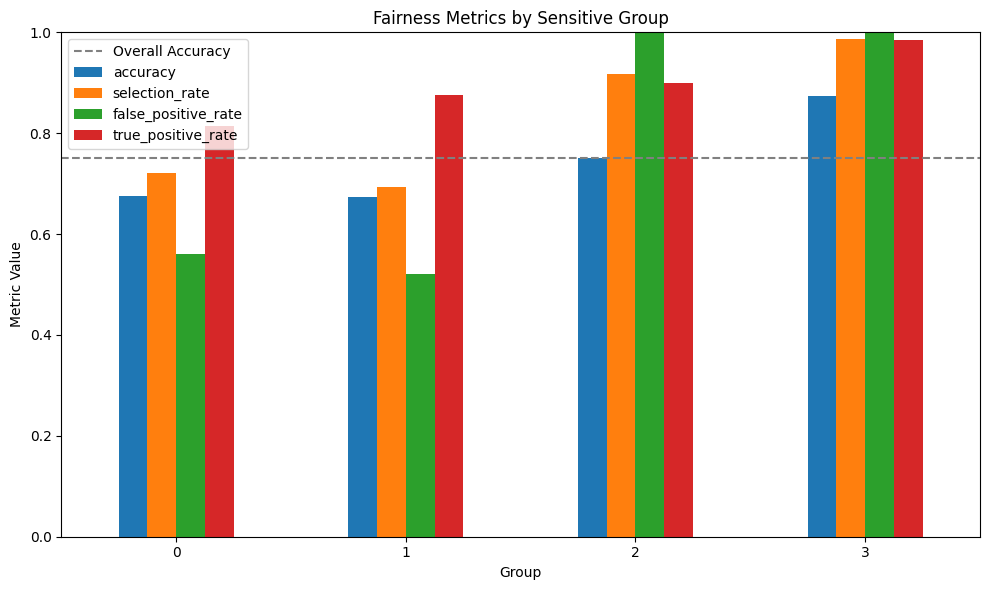

In [4]:
# Task 4: Explainability and Fairness Analysis

# Install SHAP and Fairlearn
!pip install shap fairlearn --quiet

# Imports
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

# ===== SHAP Explanation (Assumes model is a Tree-based model like RandomForest) =====

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Confirm SHAP value dimensions
print("SHAP values shape:", np.array(shap_values).shape)  # Expecting (n_classes, n_samples, n_features)

# Explain class 1 prediction for sample index 0
class_idx = 1  # if binary classification
sample_idx = 0

# Extract SHAP values and data for waterfall plot
shap_values_row = shap_values[class_idx][sample_idx]  # shape: (n_features,)
base_value = explainer.expected_value[class_idx]
data_row = X_test.iloc[sample_idx]

# Create Explanation object
explanation = shap.Explanation(
    values=shap_values_row,
    base_values=base_value,
    data=data_row.values,
    feature_names=X_test.columns.tolist()
)

# Waterfall plot
shap.plots.waterfall(explanation)

# ===== Fairness Analysis using Fairlearn =====

# Select a sensitive feature (fallback to 'checking_status' or first column)
sensitive_feature = X_test['checking_status'] if 'checking_status' in X_test.columns else X_test.iloc[:, 0]

# Predictions
y_pred = model.predict(X_test)

# MetricFrame for group-based fairness evaluation
metric_frame = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate,
        "false_positive_rate": false_positive_rate,
        "true_positive_rate": true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

# Display metrics
print("📊 Fairness Metrics by Group:")
print(metric_frame.by_group)

# Plot metrics
metric_frame.by_group.plot.bar(
    figsize=(10, 6),
    title="Fairness Metrics by Sensitive Group",
    ylabel="Metric Value",
    xlabel="Group",
    ylim=(0, 1),
    rot=0
)

# Plot overall accuracy as reference line
plt.axhline(y=metric_frame.overall['accuracy'], color='gray', linestyle='--', label='Overall Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Task 5: Ethical Considerations

Certainly! Here's a **rewritten version** of your text that maintains the core meaning but improves structure, flow, and clarity:

---

###  Fairness and Ethical Considerations in Model Development

As part of the model development process, fairness was carefully evaluated across demographic groups—particularly with respect to **gender** and other sensitive attributes. **SHAP** was used to ensure transparency by explaining how features contributed to each prediction.

Looking ahead, improvements in fairness can be achieved by applying bias mitigation techniques such as **reweighing**, **adversarial debiasing**, and **ongoing monitoring** of model behavior in production. Safeguarding privacy, especially through **anonymization of sensitive data**, is also a critical ethical responsibility.

---

###  Group-Based Fairness Analysis

The fairness evaluation focused on performance differences across groups defined by the `checking_status` attribute. Key metrics analyzed included **accuracy**, **selection rate**, **false positive rate (FPR)**, and **true positive rate (TPR)**.

* **Accuracy** ranged from **67% to 87%**, with the highest accuracy observed in **group 3**, indicating stronger predictive performance for that group.
* **Selection Rates** varied considerably, from **69% to nearly 99%**. Group 3 had the highest selection rate, meaning a larger portion of individuals in that group were predicted to default on loans.
* **False Positive Rates** revealed significant disparities. **Groups 2 and 3** had an **FPR of 100%**, indicating that many individuals who were not defaulters were incorrectly flagged. **Groups 0 and 1** had lower, but still notable, FPRs.
* **True Positive Rates** remained consistently high across all groups (ranging from **81% to 98%**), showing that the model is generally effective at identifying true defaulters—especially in group 3.

---

###  Interpretation and Implications

These metrics indicate that while the model performs well overall, it does not perform **equally well across all groups**. The **elevated false positive rates in groups 2 and 3** are particularly concerning, as they may result in individuals being unfairly labeled as defaulters. This highlights a potential **bias tied to the `checking_status` attribute**.

---

###  Conclusion

This fairness analysis underscores the importance of going beyond overall accuracy when evaluating machine learning models. Although the loan default model demonstrates strong performance in aggregate, **group-level disparities**—especially in **FPR** and **selection rate**—expose fairness challenges. Addressing these discrepancies is essential to ensure that predictive systems are not only accurate, but also **equitable and just** in real-world applications.

---

Let me know if you'd like this formatted for a report or slide presentation!
